This python code is used to assess LTCI(EF,PR)

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from netCDF4 import Dataset, MFDataset
import matplotlib.pyplot as plt
import glob
from datetime import datetime, timedelta
from scipy import stats
from sklearn.metrics import mean_squared_error
import shutil
from scipy.spatial import distance
import metpy

import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import sys, os, time, warnings
warnings.filterwarnings(action='ignore')
warnings.simplefilter(action='ignore')

In [2]:
import xesmf as xe
var_name = 't2max'

vfile = sorted(glob.glob('/land1/GloSea/G6_HCST/'+var_name+'/*.nc'))
data = xr.open_dataset(vfile[0])
data.coords['longitude'] = (data.coords['longitude'] + 180) % 360 - 180
data = data.sortby(data.longitude).sel(latitude=slice(-60,90))
# print(data)
# sys.exit()

ds_out = xr.Dataset({"lat": (["lat"], data.latitude.values), "lon": (["lon"], data.longitude.values), })

In [3]:
import xesmf as xe

vfile = sorted(glob.glob('/land1/MSWEP/v2.8/Past/Daily/*.nc'))
# print(vfile[4450])
# print(vfile[13877])
# sys.exit()

data = xr.open_mfdataset(vfile[4450:13877],concat_dim='time',combine='nested')['precipitation']
# sys.exit()

# data = data.rename({'longitude': 'lon', 'latitude': 'lat'})
# data.coords['lon'] = (data.coords['lon'] + 180) % 360 - 180
# data = data.sortby(data.lon)
data = data.reindex(lat=data.lat[::-1])

regridder = xe.Regridder(data, ds_out, "bilinear")
pr_rgd = regridder(data).sel(lat=slice(-60,90))
del data

In [4]:
vfile = sorted(glob.glob('/land1/GLEAM/v3.5a/daily/*/SH_*_GLEAM_v3.5a.nc'))
# print(vfile[11:37])
# sys.exit()

data = xr.open_mfdataset(vfile[11:37],concat_dim='time',combine='nested')['SH']
# sys.exit()

# data = data.rename({'longitude': 'lon', 'latitude': 'lat'})
# data.coords['lon'] = (data.coords['lon'] + 180) % 360 - 180
# data = data.sortby(data.lon)
data = data.reindex(lat=data.lat[::-1])

regridder = xe.Regridder(data, ds_out, "bilinear")
sh_rgd = regridder(data).sel(lat=slice(-60,90))
del data

In [11]:
vfile = sorted(glob.glob('/land1/GLEAM/v3.5a/daily/*/Et_*_GLEAM_v3.5a.nc'))
# print(vfile[11:37])
# sys.exit()

data = xr.open_mfdataset(vfile[11:37],concat_dim='time',combine='nested')['Et']
# sys.exit()

# data = data.rename({'longitude': 'lon', 'latitude': 'lat'})
# data.coords['lon'] = (data.coords['lon'] + 180) % 360 - 180
# data = data.sortby(data.lon)
data = data.reindex(lat=data.lat[::-1])

regridder = xe.Regridder(data, ds_out, "bilinear")
et_rgd = regridder(data).sel(lat=slice(-60,90))
del data

In [12]:
lh_rgd = et_rgd * 28.94
ef_rgd = lh_rgd / (lh_rgd+sh_rgd)
del et_rgd, lh_rgd, sh_rgd

In [6]:
vfile = sorted(glob.glob('/land1/GLEAM/v3.5a/daily/*/SMsurf_*_GLEAM_v3.5a.nc'))
# print(vfile[11:37])
# sys.exit()

data = xr.open_mfdataset(vfile[11:37],concat_dim='time',combine='nested')['SMsurf']
# sys.exit()

# data = data.rename({'longitude': 'lon', 'latitude': 'lat'})
# data.coords['lon'] = (data.coords['lon'] + 180) % 360 - 180
# data = data.sortby(data.lon)
data = data.reindex(lat=data.lat[::-1])

regridder = xe.Regridder(data, ds_out, "bilinear")
sm_rgd = regridder(data)
del data

In [58]:
def cal_tci_xr(a, b, dim):
    """
    Parameters
    ----------
    a : xarray
        source variable
    b : xarray
        target variable
    dim : string
        dimension along which to compute test
    
    Returns
    -------
    TCI : xarray
        calculated TCI
    R : xarray
        calculated R of TCI
    STD : xarray
        calculated STD of TCI
    """
    R = xr.corr(a,b,dim)
    STD = b.std(dim)
    return R*STD, R, STD

def cal_tci_xr2(a, b, dim):
    """
    Parameters
    ----------
    a : xarray
        source variable
    b : xarray
        target variable
    dim : string
        dimension along which to compute test
    
    Returns
    -------
    TCI : xarray
        calculated TCI
    R : xarray
        calculated R of TCI
    STD : xarray
        calculated STD of TCI
    """
    R = xr.corr(a,b,dim).values
    STD = b.std(dim).values
    return R*STD, R, STD

def area_avg_weight(a, lon_str, lat_str):
    weights = np.cos(np.deg2rad(a.lat))
    weights.name = "weights"
    a_weighted = a.weighted(weights)
    weighted_mean = a_weighted.mean(("lon", "lat"))
    return weighted_mean.values.item()

country_borders = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_boundary_lines_land',
    scale='50m',
    facecolor='none')

In [59]:
dir='/land1/GloSea/G5_HCST/'

ens_g5 = 3
syear_g5 = 1993
eyear_g5 = 2016
season_g5 = "MJJA"

if season_g5 == "JJA":
    mons = [x for x in range(6,9)]
elif season_g5 == "DJF":
    mons = [1,2,12]
elif season_g5 == "MAM":
    mons = [x for x in range(3,6)]
elif season_g5 == "SON":
    mons = [x for x in range(9,12)]
elif season_g5 == "MJJAS":
    mons = [x for x in range(5,10)]
elif season_g5 == "MJJA":
    mons = [x for x in range(5,9)]
    
years = [x for x in range(syear_g5,eyear_g5+1)]
days = ['01', '09', '17', '25']
init_dates = [None] * len(mons) * len(days)

cnt = 0
for im in mons:
    for id in days:
        init_dates[cnt] = '{:02d}{}'.format(im,id)
        cnt = cnt + 1
        

tci_dy_g5 = xr.DataArray(data = np.empty([3,len(years),ens_g5,len(init_dates),len(ds_out.lat),len(ds_out.lon)]) * np.nan,
                         dims=["comps","years","ensembles","init_dates","lat","lon"],
                         coords = dict(comps=(["comps"], [x for x in range(3)]),
                                       years=(["years"], years),
                                       ensembles=(["ensembles"], [x for x in range(ens_g5)]),
                                       init_dates=(["init_dates"], init_dates),
                                       lat=(["lat"], ds_out.lat.values),
                                       lon=(["lon"], ds_out.lon.values),
                                      )
                        )

tci_dy_obs = xr.DataArray(data = np.empty([3,len(years),len(init_dates),len(ds_out.lat),len(ds_out.lon)]) * np.nan,
                          dims=["comps","years","init_dates","lat","lon"],
                          coords = dict(comps=(["comps"], [x for x in range(3)]),
                                        years=(["years"], years),
                                        init_dates=(["init_dates"], init_dates),
                                        lat=(["lat"], ds_out.lat.values),
                                        lon=(["lon"], ds_out.lon.values),
                                       )
                         )

g5_pr = xr.DataArray(data = np.empty([len(years),ens_g5,len(init_dates),len(ds_out.lat),len(ds_out.lon)]) * np.nan, 
                     dims=["years","ensembles","init_dates","lat","lon"],
                     coords = dict(years=(["years"], years),
                                   ensembles=(["ensembles"], [x for x in range(ens_g5)]),
                                   init_dates=(["init_dates"], init_dates),
                                   lat=(["lat"], ds_out.lat.values),
                                   lon=(["lon"], ds_out.lon.values),
                                  )
                    )
g5_ef  = g5_pr.copy(deep=True)

obs_pr = xr.DataArray(data = np.empty([len(years),len(init_dates),len(ds_out.lat),len(ds_out.lon)]) * np.nan, 
                      dims=["years","init_dates","lat","lon"],
                      coords = dict(years=(["years"], years),
                                    init_dates=(["init_dates"], init_dates),
                                    lat=(["lat"], ds_out.lat.values),
                                    lon=(["lon"], ds_out.lon.values),
                                   )
                     )
obs_ef  = obs_pr.copy(deep=True)

for y,yr in enumerate(years):
    print(yr)
    for i,id in enumerate(init_dates):
        # print(yr,id)
        vfile = sorted(glob.glob(dir+'precip/'+str(yr)+id+'*.nc'))
        data1 = xr.open_mfdataset(vfile, concat_dim='ens', combine='nested')['precip'].isel(surface=0)
        data1.coords['longitude'] = (data1.coords['longitude'] + 180) % 360 - 180
        data1 = data1.sortby(data1.longitude)
        data1 = data1.rename({'t': 'time', 'longitude': 'lon', 'latitude': 'lat'}).sel(lat=slice(-60,90))
        pr = data1.resample(time='1D',base=0,keep_attrs=True).mean(keep_attrs=True)
        del data1
        
        vfile = sorted(glob.glob(dir+'lh/'+str(yr)+id+'*.nc'))
        data1 = xr.open_mfdataset(vfile, concat_dim='ens', combine='nested')['lh'].isel(surface=0)
        data1.coords['longitude'] = (data1.coords['longitude'] + 180) % 360 - 180
        data1 = data1.sortby(data1.longitude)
        lh = data1.rename({'t': 'time', 'longitude': 'lon', 'latitude': 'lat'}).sel(lat=slice(-60,90)).isel(time=slice(0,60))
        del data1
        
        vfile = sorted(glob.glob(dir+'sh/'+str(yr)+id+'*.nc'))
        data1 = xr.open_mfdataset(vfile, concat_dim='ens', combine='nested')['sh'].isel(surface=0)
        data1.coords['longitude'] = (data1.coords['longitude'] + 180) % 360 - 180
        data1 = data1.sortby(data1.longitude)
        sh = data1.rename({'t': 'time', 'longitude': 'lon', 'latitude': 'lat'}).sel(lat=slice(-60,90)).isel(time=slice(0,60))
        del data1
        
        ef = lh / (lh+sh)
        del lh, sh
        
        g5_ef[y,:,i,:,:] = ef.isel(time=slice(0,30)).mean(dim='time').values
        g5_pr[y,:,i,:,:] = pr.isel(time=slice(30,60)).mean(dim='time').values
        
        init_date = pd.to_datetime(str(yr)+id, format='%Y%m%d')
        time_day = pd.date_range(start=init_date, periods=60, freq='D')
        
        obs_ef[y,i,:,:] = ef_rgd.sel(time=slice(time_day[0],time_day[29])).mean(dim='time').values
        obs_pr[y,i,:,:] = pr_rgd.sel(time=slice(time_day[30],time_day[59])).mean(dim='time').values
        
        
        ef1 = ef.isel(time=slice(0,59))
        pr1 = pr.isel(time=slice(1,60))
        time_bk = ef1.time
        pr1 = pr1.assign_coords({"time": (time_bk)})
        
        tci_dy_g5[0,y,:,i,:,:], tci_dy_g5[1,y,:,i,:,:], tci_dy_g5[2,y,:,i,:,:] = cal_tci_xr2(ef1,pr1,'time')
        del ef, ef1, pr, pr1
        
        
        ef1 = ef_rgd.sel(time=slice(time_day[0],time_day[58]))
        pr1 = pr_rgd.sel(time=slice(time_day[1],time_day[59]))
        time_bk = ef1.time
        pr1 = pr1.assign_coords({"time": (time_bk)})
        tci_dy_obs[0,y,i,:,:], tci_dy_obs[1,y,i,:,:], tci_dy_obs[2,y,i,:,:] = cal_tci_xr(ef1,pr1,'time')
        del ef1, pr1
        

1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016


In [60]:
dir='/land1/GloSea/G6_HCST/'

ens_g6 = 7
syear_g6 = 1993
eyear_g6 = 2016
season_g6 = "MJJA"

if season_g6 == "JJA":
    mons = [x for x in range(6,9)]
elif season_g6 == "DJF":
    mons = [1,2,12]
elif season_g6 == "MAM":
    mons = [x for x in range(3,6)]
elif season_g6 == "SON":
    mons = [x for x in range(9,12)]
elif season_g6 == "MJJAS":
    mons = [x for x in range(5,10)]
elif season_g6 == "MJJA":
    mons = [x for x in range(5,9)]
    
years = [x for x in range(syear_g6,eyear_g6+1)]
days = ['01', '09', '17', '25']
init_dates = [None] * len(mons) * len(days)

cnt = 0
for im in mons:
    for id in days:
        init_dates[cnt] = '{:02d}{}'.format(im,id)
        cnt = cnt + 1
        


tci_dy_g6 = xr.DataArray(data = np.empty([3,len(years),ens_g6,len(init_dates),len(ds_out.lat),len(ds_out.lon)]) * np.nan,
                         dims=["comps","years","ensembles","init_dates","lat","lon"],
                         coords = dict(comps=(["comps"], [x for x in range(3)]),
                                       years=(["years"], years),
                                       ensembles=(["ensembles"], [x for x in range(ens_g6)]),
                                       init_dates=(["init_dates"], init_dates),
                                       lat=(["lat"], ds_out.lat.values),
                                       lon=(["lon"], ds_out.lon.values),
                                      )
                        )
g6_pr = xr.DataArray(data = np.empty([len(years),ens_g6,len(init_dates),len(ds_out.lat),len(ds_out.lon)]) * np.nan, 
                     dims=["years","ensembles","init_dates","lat","lon"],
                     coords = dict(years=(["years"], years),
                                   ensembles=(["ensembles"], [x for x in range(ens_g6)]),
                                   init_dates=(["init_dates"], init_dates),
                                   lat=(["lat"], ds_out.lat.values),
                                   lon=(["lon"], ds_out.lon.values),
                                  )
                    )
g6_ef  = g6_pr.copy(deep=True)

for y,yr in enumerate(years):
    print(yr)
    for i,id in enumerate(init_dates):
        # print(yr,id)
        vfile = sorted(glob.glob(dir+'precip/'+str(yr)+id+'*.nc'))
        data1 = xr.open_mfdataset(vfile, concat_dim='ens', combine='nested')['precip'].isel(surface=0)
        data1.coords['longitude'] = (data1.coords['longitude'] + 180) % 360 - 180
        data1 = data1.sortby(data1.longitude)
        data1 = data1.rename({'t': 'time', 'longitude': 'lon', 'latitude': 'lat'}).sel(lat=slice(-60,90))
        pr = data1.resample(time='1D',base=0,keep_attrs=True).mean(keep_attrs=True)
        del data1
        
        vfile = sorted(glob.glob(dir+'lh/'+str(yr)+id+'*.nc'))
        data1 = xr.open_mfdataset(vfile, concat_dim='ens', combine='nested')['lh'].isel(surface=0)
        data1.coords['longitude'] = (data1.coords['longitude'] + 180) % 360 - 180
        data1 = data1.sortby(data1.longitude)
        lh = data1.rename({'t': 'time', 'longitude': 'lon', 'latitude': 'lat'}).sel(lat=slice(-60,90)).isel(time=slice(0,60))
        del data1
        
        vfile = sorted(glob.glob(dir+'sh/'+str(yr)+id+'*.nc'))
        data1 = xr.open_mfdataset(vfile, concat_dim='ens', combine='nested')['sh'].isel(surface=0)
        data1.coords['longitude'] = (data1.coords['longitude'] + 180) % 360 - 180
        data1 = data1.sortby(data1.longitude)
        sh = data1.rename({'t': 'time', 'longitude': 'lon', 'latitude': 'lat'}).sel(lat=slice(-60,90)).isel(time=slice(0,60))
        del data1
        
        ef = lh / (lh+sh)
        del lh, sh
        
        g6_ef[y,:,i,:,:] = ef.isel(time=slice(0,30)).mean(dim='time').values
        g6_pr[y,:,i,:,:] = pr.isel(time=slice(30,60)).mean(dim='time').values
        
        ef1 = ef.isel(time=slice(0,59))
        pr1 = pr.isel(time=slice(1,60))
        time_bk = ef1.time
        pr1 = pr1.assign_coords({"time": (time_bk)})
        
        tci_dy_g6[0,y,:,i,:,:], tci_dy_g6[1,y,:,i,:,:], tci_dy_g6[2,y,:,i,:,:] = cal_tci_xr(ef1,pr1,'time')
        del ef, ef1, pr, pr1
        

1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016


In [61]:
tci_mn_obs = xr.DataArray(data = np.empty([3,len(init_dates),len(ds_out.lat),len(ds_out.lon)]) * np.nan,
                          dims=["comps","init_dates","lat","lon"],
                          coords = dict(comps=(["comps"], [x for x in range(3)]),
                                        init_dates=(["init_dates"], init_dates),
                                        lat=(["lat"], ds_out.lat.values),
                                        lon=(["lon"], ds_out.lon.values),
                                       )
                         )
tci_mn_g5 = xr.DataArray(data = np.empty([3,ens_g5,len(init_dates),len(ds_out.lat),len(ds_out.lon)]) * np.nan,
                         dims=["comps","ensembles","init_dates","lat","lon"],
                         coords = dict(comps=(["comps"], [x for x in range(3)]),
                                       ensembles=(["ensembles"], [x for x in range(ens_g5)]),
                                       init_dates=(["init_dates"], init_dates),
                                       lat=(["lat"], ds_out.lat.values),
                                       lon=(["lon"], ds_out.lon.values),
                                      )
                        )
tci_mn_g6 = xr.DataArray(data = np.empty([3,ens_g6,len(init_dates),len(ds_out.lat),len(ds_out.lon)]) * np.nan,
                         dims=["comps","ensembles","init_dates","lat","lon"],
                         coords = dict(comps=(["comps"], [x for x in range(3)]),
                                       ensembles=(["ensembles"], [x for x in range(ens_g6)]),
                                       init_dates=(["init_dates"], init_dates),
                                       lat=(["lat"], ds_out.lat.values),
                                       lon=(["lon"], ds_out.lon.values),
                                      )
                        )

tci_mn_obs[0,:,:,:], tci_mn_obs[1,:,:,:], tci_mn_obs[2,:,:,:] = cal_tci_xr(obs_ef, obs_pr, 'years')
tci_mn_g5[0,:,:,:,:], tci_mn_g5[1,:,:,:,:], tci_mn_g5[2,:,:,:,:] = cal_tci_xr(g5_ef, g5_pr, 'years')
tci_mn_g6[0,:,:,:,:], tci_mn_g6[1,:,:,:,:], tci_mn_g6[2,:,:,:,:] = cal_tci_xr(g6_ef, g6_pr, 'years')

In [84]:
nrows = 2
ncols = 3

plot_maps = xr.DataArray(data = np.empty([nrows*ncols,3,len(ds_out.lat),len(ds_out.lon)]) * np.nan,
                         dims=["maps","comps","lat","lon"],
                         coords = dict(maps=(["maps"], [x for x in range(nrows*ncols)]),                                  
                                       comps=(["comps"], [x for x in range(3)]),
                                       lat=(["lat"], ds_out.lat.values),
                                       lon=(["lon"], ds_out.lon.values),
                                      )
                        )
plot_sig = plot_maps.copy(deep=True)
plot_maps2 = plot_maps.copy(deep=True)
plot_sig2 = plot_maps.copy(deep=True)

plot_maps[0,:,:,:] = tci_dy_obs.mean(dim=('init_dates','years'))
plot_maps[1,:,:,:] = tci_dy_g5.mean(dim=('init_dates','years','ensembles')) * 3600.
plot_maps[2,:,:,:] = tci_dy_g6.mean(dim=('init_dates','years','ensembles')) * 3600.
plot_maps[3,:,:,:] = tci_dy_g6.mean(dim=('init_dates','years','ensembles')) * 3600. - tci_dy_g5.mean(dim=('init_dates','years','ensembles')) * 3600.
plot_maps[4,:,:,:] = tci_dy_g5.mean(dim=('init_dates','years','ensembles')) * 3600. - tci_dy_obs.mean(dim=('init_dates','years'))
plot_maps[5,:,:,:] = tci_dy_g6.mean(dim=('init_dates','years','ensembles')) * 3600. - tci_dy_obs.mean(dim=('init_dates','years'))
plot_sig[3,:,:,:] = stats.ttest_ind( tci_dy_g6.stack(samp=("init_dates", "years", "ensembles")), tci_dy_g5.stack(samp=("init_dates", "years", "ensembles")), axis=3, equal_var=False ).pvalue
plot_sig[4,:,:,:] = stats.ttest_ind( tci_dy_obs.stack(samp=("init_dates", "years")), tci_dy_g5.stack(samp=("init_dates", "years", "ensembles")) * 3600., axis=3, equal_var=False ).pvalue
plot_sig[5,:,:,:] = stats.ttest_ind( tci_dy_obs.stack(samp=("init_dates", "years")), tci_dy_g6.stack(samp=("init_dates", "years", "ensembles")) * 3600., axis=3, equal_var=False ).pvalue

plot_maps2[0,:,:,:] = tci_mn_obs.mean(dim=('init_dates'))
plot_maps2[1,:,:,:] = tci_mn_g5.mean(dim=('init_dates','ensembles')) * 3600.
plot_maps2[2,:,:,:] = tci_mn_g6.mean(dim=('init_dates','ensembles')) * 3600.
plot_maps2[3,:,:,:] = tci_mn_g6.mean(dim=('init_dates','ensembles')) * 3600. - tci_mn_g5.mean(dim=('init_dates','ensembles')) * 3600.
plot_maps2[4,:,:,:] = tci_mn_g5.mean(dim=('init_dates','ensembles')) * 3600. - tci_mn_obs.mean(dim=('init_dates'))
plot_maps2[5,:,:,:] = tci_mn_g6.mean(dim=('init_dates','ensembles')) * 3600. - tci_mn_obs.mean(dim=('init_dates'))
plot_sig2[3,:,:,:] = stats.ttest_ind( tci_mn_g6.stack(samp=("init_dates", "ensembles")), tci_mn_g5.stack(samp=("init_dates", "ensembles")), axis=3, equal_var=False ).pvalue
plot_sig2[4,:,:,:] = stats.ttest_ind( tci_mn_obs.transpose('comps', 'lat', 'lon', 'init_dates'), tci_mn_g5.stack(samp=("init_dates", "ensembles")) * 3600., axis=3, equal_var=False ).pvalue
plot_sig2[5,:,:,:] = stats.ttest_ind( tci_mn_obs.transpose('comps', 'lat', 'lon', 'init_dates'), tci_mn_g6.stack(samp=("init_dates", "ensembles")) * 3600., axis=3, equal_var=False ).pvalue

In [104]:
plot_maps[0,1,:,:] = tci_dy_obs.isel(comps=1).mean(dim=('init_dates','years'))
plot_maps[1,1,:,:] = tci_dy_g5.isel(comps=1).mean(dim=('init_dates','years','ensembles'))
plot_maps[2,1,:,:] = tci_dy_g6.isel(comps=1).mean(dim=('init_dates','years','ensembles'))
plot_maps[3,1,:,:] = tci_dy_g6.isel(comps=1).mean(dim=('init_dates','years','ensembles')) - tci_dy_g5.isel(comps=1).mean(dim=('init_dates','years','ensembles'))
plot_maps[4,1,:,:] = tci_dy_g5.isel(comps=1).mean(dim=('init_dates','years','ensembles')) - tci_dy_obs.isel(comps=1).mean(dim=('init_dates','years'))
plot_maps[5,1,:,:] = tci_dy_g6.isel(comps=1).mean(dim=('init_dates','years','ensembles')) - tci_dy_obs.isel(comps=1).mean(dim=('init_dates','years'))
plot_sig[3,1,:,:] = stats.ttest_ind( tci_dy_g6.isel(comps=1).stack(samp=("init_dates", "years", "ensembles")), tci_dy_g5.isel(comps=1).stack(samp=("init_dates", "years", "ensembles")), axis=2, equal_var=False ).pvalue
plot_sig[4,1,:,:] = stats.ttest_ind( tci_dy_obs.isel(comps=1).stack(samp=("init_dates", "years")), tci_dy_g5.isel(comps=1).stack(samp=("init_dates", "years", "ensembles")), axis=2, equal_var=False ).pvalue
plot_sig[5,1,:,:] = stats.ttest_ind( tci_dy_obs.isel(comps=1).stack(samp=("init_dates", "years")), tci_dy_g6.isel(comps=1).stack(samp=("init_dates", "years", "ensembles")), axis=2, equal_var=False ).pvalue

plot_maps2[0,1,:,:] = tci_mn_obs.isel(comps=1).mean(dim=('init_dates'))
plot_maps2[1,1,:,:] = tci_mn_g5.isel(comps=1).mean(dim=('init_dates','ensembles'))
plot_maps2[2,1,:,:] = tci_mn_g6.isel(comps=1).mean(dim=('init_dates','ensembles'))
plot_maps2[3,1,:,:] = tci_mn_g6.isel(comps=1).mean(dim=('init_dates','ensembles')) - tci_mn_g5.isel(comps=1).mean(dim=('init_dates','ensembles'))
plot_maps2[4,1,:,:] = tci_mn_g5.isel(comps=1).mean(dim=('init_dates','ensembles')) - tci_mn_obs.isel(comps=1).mean(dim=('init_dates'))
plot_maps2[5,1,:,:] = tci_mn_g6.isel(comps=1).mean(dim=('init_dates','ensembles')) - tci_mn_obs.isel(comps=1).mean(dim=('init_dates'))
plot_sig2[3,1,:,:] = stats.ttest_ind( tci_mn_g6.isel(comps=1).stack(samp=("init_dates", "ensembles")), tci_mn_g5.isel(comps=1).stack(samp=("init_dates", "ensembles")), axis=2, equal_var=False ).pvalue
plot_sig2[4,1,:,:] = stats.ttest_ind( tci_mn_obs.isel(comps=1).transpose('lat', 'lon', 'init_dates'), tci_mn_g5.isel(comps=1).stack(samp=("init_dates", "ensembles")), axis=2, equal_var=False ).pvalue
plot_sig2[5,1,:,:] = stats.ttest_ind( tci_mn_obs.isel(comps=1).transpose('lat', 'lon', 'init_dates'), tci_mn_g6.isel(comps=1).stack(samp=("init_dates", "ensembles")), axis=2, equal_var=False ).pvalue

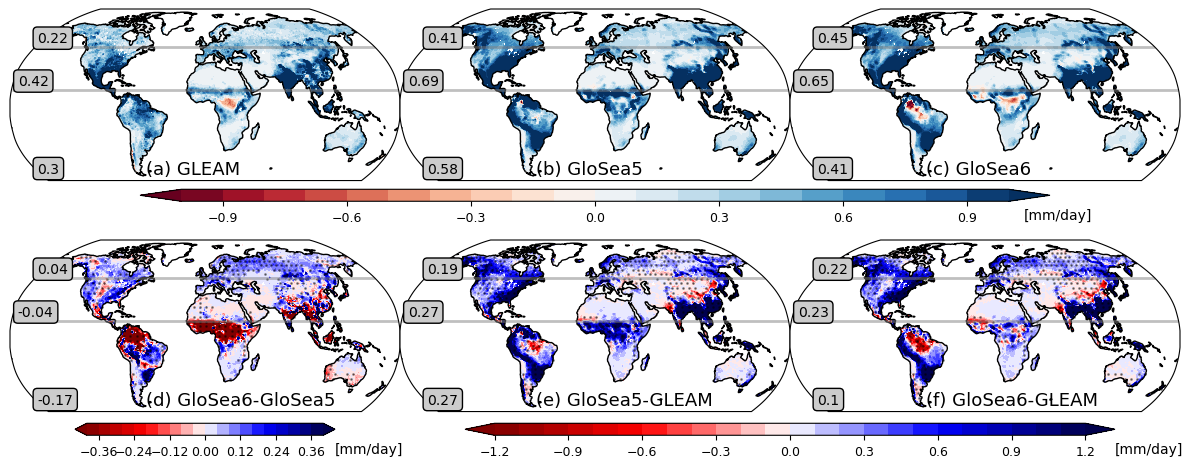

In [100]:
import string
alphabet = list(string.ascii_lowercase)

nrows = 2
ncols = 3

map_name = 'AC_EF_PR_dy'
ci = 0
titles = ['(a) GLEAM','(b) GloSea5','(c) GloSea6','(d) GloSea6-GloSea5','(e) GloSea5-GLEAM','(f) GloSea6-GLEAM']
units = ['mm/day','mm/day','mm/day']

fname='./fig/'+map_name+'_maps_MJJA.png'

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.Robinson(central_longitude=0)},
                        figsize=(13,6))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the models
for pp in range(nrows*ncols):
    data = plot_maps.isel(maps=pp,comps=ci).sel(lat=slice(-60,90)).where(plot_maps.isel(maps=0,comps=0).sel(lat=slice(-60,90))>=-1.)
    data3 = plot_sig.isel(maps=pp,comps=ci).sel(lat=slice(-60,90)).where(plot_maps.isel(maps=0,comps=0).sel(lat=slice(-60,90))>=-1.)
        
    dint=7
    
    
    if pp==3:
        cmaps = 'seismic_r'
        clevs = np.arange(-0.4,0.44,0.04)
        des = 2
    elif pp==4 or pp==5:
        cmaps = 'seismic_r'
        clevs = np.arange(-1.2,1.3,0.1)
        des = 2
    else:
        cmaps = 'RdBu'
        clevs = np.arange(-1.0,1.1,0.1)
        des = 2
        
    
    lon2d, lat2d = np.meshgrid(data.lon, data.lat)
    
    cs = axs[pp].contourf(lon2d,lat2d,data,clevs,
                      transform = ccrs.PlateCarree(),
                      cmap=cmaps,extend='both')
    if pp==0:
        cs1 = cs
    elif pp==3:
        cs2 = cs
    elif pp==4:
        cs3 = cs
    
    # axs[pp].contourf(bias_map.lon,bias_map.lat, sig_map[pp,:,:].where(sig_map[pp,:,:]<=0.01), hatches=["."], alpha=0)
    lon2d2, lat2d2 = np.meshgrid(data.lon,data.lat)
    lon_sig = data.copy()
    lon_sig = lon_sig.where(False, lon2d2)
    lon_sig = lon_sig.where(data3<=0.05, np.nan)
    lat_sig = data.copy()
    lat_sig = lat_sig.where(False, lat2d2)
    lat_sig = lat_sig.where(data3<=0.05, np.nan)
    axs[pp].plot(lon_sig[::dint,::dint], lat_sig[::dint,::dint],'.',color='black',markersize=2, alpha=0.4,transform = ccrs.PlateCarree())
    
    # Title each subplot with the name of the model
    # if pp//ncols == 0:
    #     axs[pp].set_title(titles[pp], fontsize=14)
    # axs[pp].set_title(titles[pp],x=0.18,y=0.02, fontsize=14)
        
    # if pp%ncols == 0:
    #     axs[pp].set_ylabel(var_names[pp//ncols])
        
    # Draw the coastines for each subplot
    axs[pp].coastlines()
    
    # Draw the country borders
    # axs[pp].add_feature(country_borders, edgecolor='gray', linestyle='-', linewidth=1)
    
    # Draw the STATES borders
    # axs[pp].cfeature.STATES()
    # Add state boundaries to plot
    # axs[pp].add_feature(cfeature.STATES, edgecolor='gray', linestyle='--', linewidth=0.8, alpha=0.5)
    
    
    aave1 = area_avg_weight(data.sel(lat=slice(50,90)), 'lon', 'lat')
    aave2 = area_avg_weight(data.sel(lat=slice(15,50)), 'lon', 'lat')
    aave3 = area_avg_weight(data.sel(lat=slice(-60,15)), 'lon', 'lat')
    
    bbox = dict(boxstyle ="round", fc ="0.8") 
    
    axs[pp].annotate('{}'.format(round(aave1,des)),xy=(0.07, 0.83), xycoords='axes fraction',
                     horizontalalignment='left', verticalalignment='center', color='black', fontsize=10, bbox=bbox)
    axs[pp].annotate('{}'.format(round(aave2,des)),xy=(0.02, 0.58), xycoords='axes fraction',
                     horizontalalignment='left', verticalalignment='center', color='black', fontsize=10, bbox=bbox)
    axs[pp].annotate('{}'.format(round(aave3,des)),xy=(0.07, 0.07), xycoords='axes fraction',
                     horizontalalignment='left', verticalalignment='center', color='black', fontsize=10, bbox=bbox)

    axs[pp].gridlines(ylocs=[15, 50], xlocs=[], color='gray', linewidth=2, alpha=0.5);
    

    axs[pp].annotate('{}'.format(titles[pp]),xy=(0.35, 0.07), xycoords='axes fraction',
                     horizontalalignment='left', verticalalignment='center', color='black', fontsize=13)
    
    

# Delete the unwanted axes
# for i in [7,8]:
#     fig.delaxes(axs[i])

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.13, top=0.9, left=0.05, right=0.95,
                    wspace=0.0, hspace=0.0) # wspace: horizontal space, hspace: vertical space,



# sys.exit()

# Add a colorbar axis at the bottom of the graph
cbar_ax1 = fig.add_axes([0.15, 0.53, 0.7, 0.02])
cbar_ax2 = fig.add_axes([0.1, 0.14, 0.2, 0.02])
cbar_ax3 = fig.add_axes([0.4, 0.14, 0.5, 0.02])

# Draw the colorbar
cbar1=fig.colorbar(cs1, cax=cbar_ax1,orientation='horizontal')
cbar1.ax.tick_params(labelsize=9)

cbar2=fig.colorbar(cs2, cax=cbar_ax2,orientation='horizontal')
cbar2.ax.tick_params(labelsize=9)

cbar3=fig.colorbar(cs3, cax=cbar_ax3,orientation='horizontal')
cbar3.ax.tick_params(labelsize=9)

fig.text(0.83,0.50, '[{}]'.format(units[0]), color='black', size=10, rotation=0, horizontalalignment="left")
fig.text(0.30,0.11, '[{}]'.format(units[1]), color='black', size=10, rotation=0, horizontalalignment="left")
fig.text(0.90,0.11, '[{}]'.format(units[2]), color='black', size=10, rotation=0, horizontalalignment="left")

plt.savefig(fname, dpi=300, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

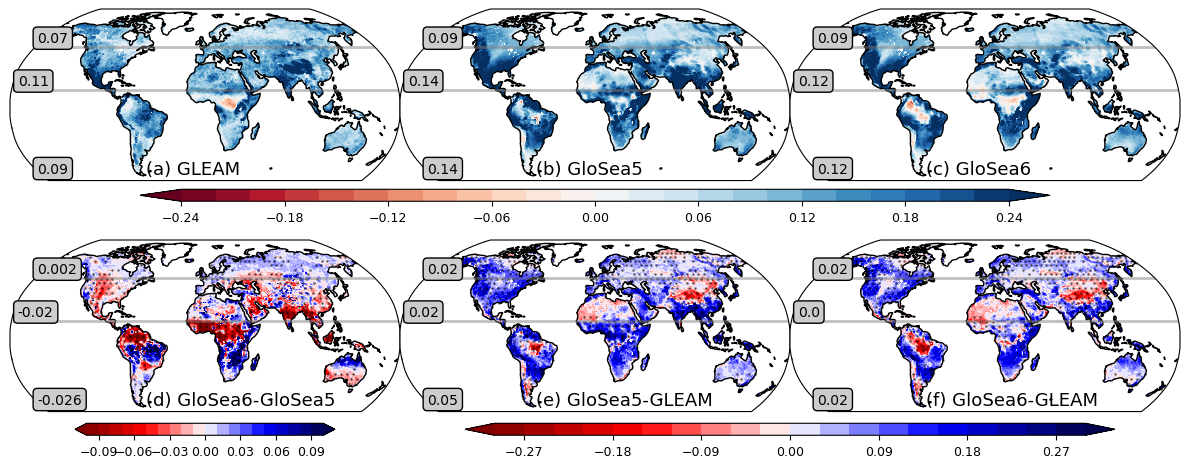

In [107]:
import string
alphabet = list(string.ascii_lowercase)

nrows = 2
ncols = 3

map_name = 'R_EF_PR_dy'
ci = 1
titles = ['(a) GLEAM','(b) GloSea5','(c) GloSea6','(d) GloSea6-GloSea5','(e) GloSea5-GLEAM','(f) GloSea6-GLEAM']
units = ['mm/day','mm/day','mm/day']

fname='./fig/'+map_name+'_maps_MJJA.png'

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.Robinson(central_longitude=0)},
                        figsize=(13,6))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the models
for pp in range(nrows*ncols):
    data = plot_maps.isel(maps=pp,comps=ci).sel(lat=slice(-60,90)).where(plot_maps.isel(maps=0,comps=0).sel(lat=slice(-60,90))>=-1.)
    data3 = plot_sig.isel(maps=pp,comps=ci).sel(lat=slice(-60,90)).where(plot_maps.isel(maps=0,comps=0).sel(lat=slice(-60,90))>=-1.)
        
    dint=7
    
   
    if pp==3:
        cmaps = 'seismic_r'
        clevs = np.arange(-0.1,0.11,0.01)
        des = 3
    elif pp==4 or pp==5:
        cmaps = 'seismic_r'
        clevs = np.arange(-0.3,0.33,0.03)
        des = 2
    else:
        cmaps = 'RdBu'
        clevs = np.arange(-0.24,0.26,0.02)
        des = 2
        
    
    lon2d, lat2d = np.meshgrid(data.lon, data.lat)
    
    cs = axs[pp].contourf(lon2d,lat2d,data,clevs,
                      transform = ccrs.PlateCarree(),
                      cmap=cmaps,extend='both')
    if pp==0:
        cs1 = cs
    elif pp==3:
        cs2 = cs
    elif pp==4:
        cs3 = cs
    
    lon2d2, lat2d2 = np.meshgrid(data.lon,data.lat)
    lon_sig = data.copy()
    lon_sig = lon_sig.where(False, lon2d2)
    lon_sig = lon_sig.where(data3<=0.05, np.nan)
    lat_sig = data.copy()
    lat_sig = lat_sig.where(False, lat2d2)
    lat_sig = lat_sig.where(data3<=0.05, np.nan)
    axs[pp].plot(lon_sig[::dint,::dint], lat_sig[::dint,::dint],'.',color='black',markersize=2, alpha=0.4,transform = ccrs.PlateCarree())
    
    # Title each subplot with the name of the model
    # if pp//ncols == 0:
    #     axs[pp].set_title(titles[pp], fontsize=14)
    # axs[pp].set_title(titles[pp],x=0.18,y=0.02, fontsize=14)
        
    # if pp%ncols == 0:
    #     axs[pp].set_ylabel(var_names[pp//ncols])
        
    # Draw the coastines for each subplot
    axs[pp].coastlines()
    
    # Draw the country borders
    # axs[pp].add_feature(country_borders, edgecolor='gray', linestyle='-', linewidth=1)
    
    # Draw the STATES borders
    # axs[pp].cfeature.STATES()
    # Add state boundaries to plot
    # axs[pp].add_feature(cfeature.STATES, edgecolor='gray', linestyle='--', linewidth=0.8, alpha=0.5)
    
    aave1 = area_avg_weight(data.sel(lat=slice(50,90)), 'lon', 'lat')
    aave2 = area_avg_weight(data.sel(lat=slice(15,50)), 'lon', 'lat')
    aave3 = area_avg_weight(data.sel(lat=slice(-60,15)), 'lon', 'lat')
    
    bbox = dict(boxstyle ="round", fc ="0.8") 
    
    axs[pp].annotate('{}'.format(round(aave1,des)),xy=(0.07, 0.83), xycoords='axes fraction',
                     horizontalalignment='left', verticalalignment='center', color='black', fontsize=10, bbox=bbox)
    axs[pp].annotate('{}'.format(round(aave2,des)),xy=(0.02, 0.58), xycoords='axes fraction',
                     horizontalalignment='left', verticalalignment='center', color='black', fontsize=10, bbox=bbox)
    axs[pp].annotate('{}'.format(round(aave3,des)),xy=(0.07, 0.07), xycoords='axes fraction',
                     horizontalalignment='left', verticalalignment='center', color='black', fontsize=10, bbox=bbox)

    axs[pp].gridlines(ylocs=[15, 50], xlocs=[], color='gray', linewidth=2, alpha=0.5);
    
    axs[pp].annotate('{}'.format(titles[pp]),xy=(0.35, 0.07), xycoords='axes fraction',
                     horizontalalignment='left', verticalalignment='center', color='black', fontsize=13)
    
      

# Delete the unwanted axes
# for i in [7,8]:
#     fig.delaxes(axs[i])

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.13, top=0.9, left=0.05, right=0.95,
                    wspace=0.0, hspace=0.0) # wspace: horizontal space, hspace: vertical space,


# Add a colorbar axis at the bottom of the graph
cbar_ax1 = fig.add_axes([0.15, 0.53, 0.7, 0.02])
cbar_ax2 = fig.add_axes([0.1, 0.14, 0.2, 0.02])
cbar_ax3 = fig.add_axes([0.4, 0.14, 0.5, 0.02])

# Draw the colorbar
cbar1=fig.colorbar(cs1, cax=cbar_ax1,orientation='horizontal')
cbar1.ax.tick_params(labelsize=9)

cbar2=fig.colorbar(cs2, cax=cbar_ax2,orientation='horizontal')
cbar2.ax.tick_params(labelsize=9)

cbar3=fig.colorbar(cs3, cax=cbar_ax3,orientation='horizontal')
cbar3.ax.tick_params(labelsize=9)

plt.savefig(fname, dpi=300, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

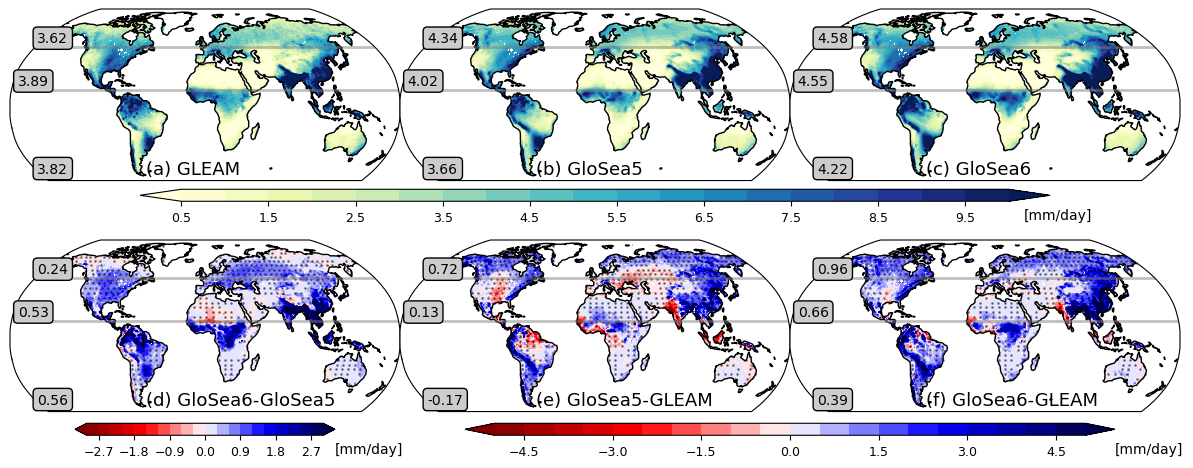

In [101]:
import string
alphabet = list(string.ascii_lowercase)

nrows = 2
ncols = 3

map_name = 'SD_EF_PR_dy'
ci = 2
titles = ['(a) GLEAM','(b) GloSea5','(c) GloSea6','(d) GloSea6-GloSea5','(e) GloSea5-GLEAM','(f) GloSea6-GLEAM']
units = ['mm/day','mm/day','mm/day']

fname='./fig/'+map_name+'_maps_MJJA.png'

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.Robinson(central_longitude=0)},
                        figsize=(13,6))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the models
for pp in range(nrows*ncols):
    data = plot_maps.isel(maps=pp,comps=ci).sel(lat=slice(-60,90)).where(plot_maps.isel(maps=0,comps=0).sel(lat=slice(-60,90))>=-1.)
    data3 = plot_sig.isel(maps=pp,comps=ci).sel(lat=slice(-60,90)).where(plot_maps.isel(maps=0,comps=0).sel(lat=slice(-60,90))>=-1.)
        
    dint=7
    
    
    if pp==3:
        cmaps = 'seismic_r'
        clevs = np.arange(-3,3.3,0.3)
        des = 2
    elif pp==4 or pp==5:
        cmaps = 'seismic_r'
        clevs = np.arange(-5,5.5,0.5)
        des = 2
    else:
        cmaps = 'YlGnBu'
        clevs = np.arange(0.5,10.5,0.5)
        des = 2
        
    
    lon2d, lat2d = np.meshgrid(data.lon, data.lat)
    
    cs = axs[pp].contourf(lon2d,lat2d,data,clevs,
                      transform = ccrs.PlateCarree(),
                      cmap=cmaps,extend='both')
    if pp==0:
        cs1 = cs
    elif pp==3:
        cs2 = cs
    elif pp==4:
        cs3 = cs
    
    lon2d2, lat2d2 = np.meshgrid(data.lon,data.lat)
    lon_sig = data.copy()
    lon_sig = lon_sig.where(False, lon2d2)
    lon_sig = lon_sig.where(data3<=0.05, np.nan)
    lat_sig = data.copy()
    lat_sig = lat_sig.where(False, lat2d2)
    lat_sig = lat_sig.where(data3<=0.05, np.nan)
    axs[pp].plot(lon_sig[::dint,::dint], lat_sig[::dint,::dint],'.',color='black',markersize=2, alpha=0.4,transform = ccrs.PlateCarree())
    
    # Title each subplot with the name of the model
    # if pp//ncols == 0:
    #     axs[pp].set_title(titles[pp], fontsize=14)
    # axs[pp].set_title(titles[pp],x=0.18,y=0.02, fontsize=14)
        
    # if pp%ncols == 0:
    #     axs[pp].set_ylabel(var_names[pp//ncols])
        
    # Draw the coastines for each subplot
    axs[pp].coastlines()
    
    # Draw the country borders
    # axs[pp].add_feature(country_borders, edgecolor='gray', linestyle='-', linewidth=1)
    
    # Draw the STATES borders
    # axs[pp].cfeature.STATES()
    # Add state boundaries to plot
    # axs[pp].add_feature(cfeature.STATES, edgecolor='gray', linestyle='--', linewidth=0.8, alpha=0.5)
    
    aave1 = area_avg_weight(data.sel(lat=slice(50,90)), 'lon', 'lat')
    aave2 = area_avg_weight(data.sel(lat=slice(15,50)), 'lon', 'lat')
    aave3 = area_avg_weight(data.sel(lat=slice(-60,15)), 'lon', 'lat')
    
    bbox = dict(boxstyle ="round", fc ="0.8") 
    
    axs[pp].annotate('{}'.format(round(aave1,des)),xy=(0.07, 0.83), xycoords='axes fraction',
                     horizontalalignment='left', verticalalignment='center', color='black', fontsize=10, bbox=bbox)
    axs[pp].annotate('{}'.format(round(aave2,des)),xy=(0.02, 0.58), xycoords='axes fraction',
                     horizontalalignment='left', verticalalignment='center', color='black', fontsize=10, bbox=bbox)
    axs[pp].annotate('{}'.format(round(aave3,des)),xy=(0.07, 0.07), xycoords='axes fraction',
                     horizontalalignment='left', verticalalignment='center', color='black', fontsize=10, bbox=bbox)

    axs[pp].gridlines(ylocs=[15, 50], xlocs=[], color='gray', linewidth=2, alpha=0.5);
    
    axs[pp].annotate('{}'.format(titles[pp]),xy=(0.35, 0.07), xycoords='axes fraction',
                     horizontalalignment='left', verticalalignment='center', color='black', fontsize=13)
    
    
# Delete the unwanted axes
# for i in [7,8]:
#     fig.delaxes(axs[i])

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.13, top=0.9, left=0.05, right=0.95,
                    wspace=0.0, hspace=0.0) # wspace: horizontal space, hspace: vertical space,


# Add a colorbar axis at the bottom of the graph
cbar_ax1 = fig.add_axes([0.15, 0.53, 0.7, 0.02])
cbar_ax2 = fig.add_axes([0.1, 0.14, 0.2, 0.02])
cbar_ax3 = fig.add_axes([0.4, 0.14, 0.5, 0.02])

# Draw the colorbar
cbar1=fig.colorbar(cs1, cax=cbar_ax1,orientation='horizontal')
cbar1.ax.tick_params(labelsize=9)

cbar2=fig.colorbar(cs2, cax=cbar_ax2,orientation='horizontal')
cbar2.ax.tick_params(labelsize=9)

cbar3=fig.colorbar(cs3, cax=cbar_ax3,orientation='horizontal')
cbar3.ax.tick_params(labelsize=9)

fig.text(0.83,0.50, '[{}]'.format(units[0]), color='black', size=10, rotation=0, horizontalalignment="left")
fig.text(0.30,0.11, '[{}]'.format(units[1]), color='black', size=10, rotation=0, horizontalalignment="left")
fig.text(0.90,0.11, '[{}]'.format(units[2]), color='black', size=10, rotation=0, horizontalalignment="left")

plt.savefig(fname, dpi=300, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

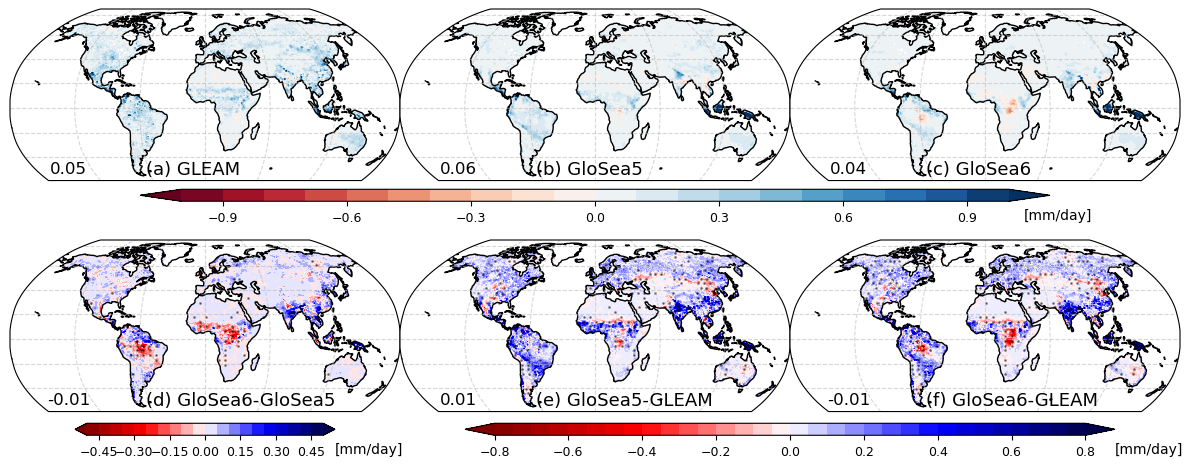

In [88]:
import string
alphabet = list(string.ascii_lowercase)

nrows = 2
ncols = 3

map_name = 'AC_EF_PR_mn'
ci = 0
titles = ['(a) GLEAM','(b) GloSea5','(c) GloSea6','(d) GloSea6-GloSea5','(e) GloSea5-GLEAM','(f) GloSea6-GLEAM']
units = ['mm/day','mm/day','mm/day']

fname='./fig/'+map_name+'_maps_MJJA.png'

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.Robinson(central_longitude=0)},
                        figsize=(13,6))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the models
for pp in range(nrows*ncols):
    data = plot_maps2.isel(maps=pp,comps=ci).sel(lat=slice(-60,90)).where(plot_maps.isel(maps=0,comps=0).sel(lat=slice(-60,90))>=-1.)
    data3 = plot_sig2.isel(maps=pp,comps=ci).sel(lat=slice(-60,90)).where(plot_maps.isel(maps=0,comps=0).sel(lat=slice(-60,90))>=-1.)
        
    dint=7
    
    
    if pp==3:
        cmaps = 'seismic_r'
        clevs = np.arange(-0.5,0.55,0.05)
        des = 2
    elif pp==4 or pp==5:
        cmaps = 'seismic_r'
        clevs = np.arange(-0.8,0.85,0.05)
        des = 2
    else:
        cmaps = 'RdBu'
        clevs = np.arange(-1.0,1.1,0.1)
        des = 2
        
    
    lon2d, lat2d = np.meshgrid(data.lon, data.lat)
    
    cs = axs[pp].contourf(lon2d,lat2d,data,clevs,
                      transform = ccrs.PlateCarree(),
                      cmap=cmaps,extend='both')
    if pp==0:
        cs1 = cs
    elif pp==3:
        cs2 = cs
    elif pp==4:
        cs3 = cs
    
    lon2d2, lat2d2 = np.meshgrid(data.lon,data.lat)
    lon_sig = data.copy()
    lon_sig = lon_sig.where(False, lon2d2)
    lon_sig = lon_sig.where(data3<=0.05, np.nan)
    lat_sig = data.copy()
    lat_sig = lat_sig.where(False, lat2d2)
    lat_sig = lat_sig.where(data3<=0.05, np.nan)
    axs[pp].plot(lon_sig[::dint,::dint], lat_sig[::dint,::dint],'.',color='black',markersize=2, alpha=0.4,transform = ccrs.PlateCarree())
    
    # Title each subplot with the name of the model
    # if pp//ncols == 0:
    #     axs[pp].set_title(titles[pp], fontsize=14)
    # axs[pp].set_title(titles[pp],x=0.18,y=0.02, fontsize=14)
        
    # if pp%ncols == 0:
    #     axs[pp].set_ylabel(var_names[pp//ncols])
        
    # Draw the coastines for each subplot
    axs[pp].coastlines()
    
    # Draw the country borders
    # axs[pp].add_feature(country_borders, edgecolor='gray', linestyle='-', linewidth=1)
    
    # Draw the STATES borders
    # axs[pp].cfeature.STATES()
    # Add state boundaries to plot
    # axs[pp].add_feature(cfeature.STATES, edgecolor='gray', linestyle='--', linewidth=0.8, alpha=0.5)
       
    aave = area_avg_weight(data, 'lon', 'lat')
    axs[pp].annotate('{}'.format(round(aave,des)),xy=(0.15, 0.07), xycoords='axes fraction',
                     horizontalalignment='center', verticalalignment='center', color='black', fontsize=12)
    
    axs[pp].annotate('{}'.format(titles[pp]),xy=(0.35, 0.07), xycoords='axes fraction',
                     horizontalalignment='left', verticalalignment='center', color='black', fontsize=13)
    
    
    # Draw gridlines except for xlabels_top and ylabels_left
    # gl = axs[pp].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.5, linestyle='--')
    # gl.xlabels_top = False
    # gl.ylabels_right = False
    # gl = axs[pp].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, alpha=0.5, linestyle='--')
    # gl.xlabel_style = {'size': 8, 'color': 'gray', 'weight': 'bold'}
    # gl.ylabel_style = {'size': 8, 'color': 'gray', 'weight': 'bold'}
    gl = axs[pp].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, alpha=0.5, linestyle='--')
    gl.xlabel_style = {'size': 8, 'color': 'gray', 'weight': 'bold'}
    gl.ylabel_style = {'size': 8, 'color': 'gray', 'weight': 'bold'}
    

# Delete the unwanted axes
# for i in [7,8]:
#     fig.delaxes(axs[i])

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.13, top=0.9, left=0.05, right=0.95,
                    wspace=0.0, hspace=0.0) # wspace: horizontal space, hspace: vertical space,



# sys.exit()

# Add a colorbar axis at the bottom of the graph
cbar_ax1 = fig.add_axes([0.15, 0.53, 0.7, 0.02])
cbar_ax2 = fig.add_axes([0.1, 0.14, 0.2, 0.02])
cbar_ax3 = fig.add_axes([0.4, 0.14, 0.5, 0.02])

# Draw the colorbar
cbar1=fig.colorbar(cs1, cax=cbar_ax1,orientation='horizontal')
cbar1.ax.tick_params(labelsize=9)

cbar2=fig.colorbar(cs2, cax=cbar_ax2,orientation='horizontal')
cbar2.ax.tick_params(labelsize=9)

cbar3=fig.colorbar(cs3, cax=cbar_ax3,orientation='horizontal')
cbar3.ax.tick_params(labelsize=9)

fig.text(0.83,0.50, '[{}]'.format(units[0]), color='black', size=10, rotation=0, horizontalalignment="left")
fig.text(0.30,0.11, '[{}]'.format(units[1]), color='black', size=10, rotation=0, horizontalalignment="left")
fig.text(0.90,0.11, '[{}]'.format(units[2]), color='black', size=10, rotation=0, horizontalalignment="left")

plt.savefig(fname, dpi=300, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()